In [1]:
include("../ToolBox/ToolBox.jl")
import FileIO
import JLD
using .ToolBox
using .Geometry
using Colors
using Dates

In [2]:
function moasic2normal_view(moasic_view,meta)
    @assert moasic_view[1].start >= meta["burst_meta"]["first_line_mosaic"][1]
    @assert moasic_view[1].stop <= (meta["burst_meta"]["first_line_mosaic"][end] + meta["lines_per_burst"])

    
    start_burst = findlast(
    meta["burst_meta"]["first_line_mosaic"].<= moasic_view[1].start)

    lines_in_first_burst = moasic_view[1].start -meta["burst_meta"]["first_line_mosaic"][start_burst] +1
    line_start = lines_in_first_burst + (start_burst-1)* meta["lines_per_burst"]

    end_burst = 0
    if moasic_view[1].stop < meta["lines_per_burst"]
        end_burst = 1
    else
        end_burst = findlast(
            (meta["burst_meta"]["first_line_mosaic"] .+meta["lines_per_burst"] ).< moasic_view[1].stop)+1
    end

    lines_in_last_burst =  moasic_view[1].stop - meta["burst_meta"]["first_line_mosaic"][end_burst] +1
    line_end = lines_in_last_burst+ (end_burst-1)* meta["lines_per_burst"]
    return [line_start:line_end,moasic_view[2]]
end


function round_2_int(float_number,tol=0.1)
    res = round(Int64,float_number)
    @assert abs(res-float_number)<tol "Rounding not within tolerance"
return res
end

using Dates
function split_large_view(large_view,meta_first,meta_second)
    ## TODO- Must be burst_wise
    c = 299792458
    azimuth_frequency =  meta_first["azimuth_frequency"]
    inv_range_pixel_spacing = (2*meta_first["range_sampling_rate"])/c
    delta_r0 = (meta_second["slant_range_time"]-meta_first["slant_range_time"])*c/2
    delta_sample = inv_range_pixel_spacing*delta_r0

    delta_sample = round_2_int(inv_range_pixel_spacing*delta_r0)

    over_lap = meta_first["samples_per_burst"]-delta_sample +1
    
    start_burst = ceil(Int64,large_view[1].start/meta_first["lines_per_burst"])
    last_valid_pixel = maximum(meta_first["burst_meta"]["last_valid_pixel"][start_burst])
    delta_minus = 1 + meta_first["samples_per_burst"] -last_valid_pixel 
    delta_plus = over_lap - delta_minus


    view_first = large_view[1],large_view[2].start:(meta_first["samples_per_burst"]-delta_minus)

    mosaic_view_first = SlcUtil.get_mosaic_view(meta_first,view_first)


    detlta_t0 = convert(Second,(meta_first["t_0"]-meta_second["t_0"]) ).value

    line_t_first_start =  (mosaic_view_first[1].start-1)/azimuth_frequency+meta_first["t_start"]
    line_second_start = round_2_int(1 + ((line_t_first_start+detlta_t0)-meta_second["t_start"])*azimuth_frequency)

    line_t_first_stop =  (mosaic_view_first[1].stop-1)/azimuth_frequency+meta_first["t_start"]
    line_second_stop= round_2_int(1 + ((line_t_first_stop+detlta_t0)-meta_second["t_start"])*azimuth_frequency)


    mosaic_view_second = [line_second_start:line_second_stop,
                        (1+delta_plus): (large_view[2].stop - delta_sample+1)]
    
    delta_line =  round_2_int( mosaic_view_first[1].start-mosaic_view_second[1].start)

    view_second = moasic2normal_view(mosaic_view_second,meta_second)
    return view_first,view_second,delta_line,delta_sample
end

function seconds_since_midnight(date_time)
    if typeof(date_time) == DateTime
        date_time_string = Dates.format(date_time, "yyyy-mm-ddTHH:MM:SS")
    elseif typeof(date_time) == String
        date_time_string = date_time
    end
    # Compute time from DateTime input.
    split_time_string = split(split(date_time_string, "T")[end], ":")
    hour_digits, minute_digits = parse.(Int, split_time_string[1:2])
    second_decimals_string = split(split_time_string[3], ".")
    if length(second_decimals_string) == 1
        sec_digits  = parse.(Int, second_decimals_string[1])
        time_now = Time(hour_digits, minute_digits, sec_digits)
    elseif length(second_decimals_string) == 2
        sec_digits, milisec_digits = parse.(Int, [second_decimals_string[1], second_decimals_string[2][1:3]])
        time_now = Time(hour_digits, minute_digits, sec_digits, milisec_digits)
    elseif length(second_decimals_string) == 3
        sec_digits, milisec_digits, microsec_digits = parse.(Int, [second_decimals_string[1], second_decimals_string[2][1:3], second_decimals_string[2][4:end]])
        time_now = Time(hour_digits, minute_digits, sec_digits, milisec_digits, microsec_digits)
    elseif length(second_decimals_string) == 4
        sec_digits, milisec_digits, microsec_digits, nanosec_digits = parse.(Int, [second_decimals_string[1], second_decimals_string[2][1:3], second_decimals_string[2][4:6], second_decimals_stringsecond_decimals_string[2][6:end]])
        time_now = Time(hour_digits, minute_digits, sec_digits, milisec_digits, microsec_digits, nanosec_digits)
    else
        println("Only down to nanoseconds supported")
    end

    # Convert midnight of date to Time object
    time_midnight = Time(DateTime(split(date_time_string, "T")[1]))

    # get integer number of nanoseconds between input time and midnight
    time_since_midnight = time_now - time_midnight
    time_since_midnight = time_since_midnight / Nanosecond(1) * 10^(-9)
    return time_since_midnight
end

seconds_since_midnight (generic function with 1 method)

In [3]:
## Eigil functions

function all_SAFE_files_v2(directory)
    files = readdir(directory)
    index = [ split(elem, ".")[end] == "SAFE" for elem in files]
    return files[index]
end 

function sort_satellite_type(files, S1_selection)
    if S1_selection == "both"
        files = files[sortperm(extract_datetime.(files))]
    elseif S1_selection == "A"
        files = files[hcat(split.(files, "_")...)[1, :] .== "S1A"]
        files = files[sortperm(extract_datetime.(files))]
    elseif S1_selection == "B"
        files = files[hcat(split.(files, "_")...)[1, :] .== "S1B"]
        files = files[sortperm(extract_datetime.(files))]
    else
        files = 0
        println("S1_selection not valid")
        
    end
    return files
end

function extract_datetime(SAFE_path; start_date=true)
    extract_SAFE_name = split(SAFE_path, "/")[end]
    if start_date
        date_string = split(extract_SAFE_name, "_")[6]
    else
        date_string = split(extract_SAFE_name, "_")[7]
    end
    year = date_string[1:4]
    month = date_string[5:6]
    day = date_string[7:8]
    hour = date_string[10:11]
    minute = date_string[12:13]
    second = date_string[14:end]
    date_int = parse.(Int, [year, month, day, hour, minute, second])
    return DateTime(date_int...)
end

function days_between_acquisitions(date1, date2)
    return Dates.value(Date(date1) - Date(date2))
end

function _file_name_generater(product_folders, polarization)
    ID = Dict{String,String}()
    master_satellite = string(split(split(product_folders[1], "/")[end], "_")[1][end])
    slave_satellite = string(split(split(product_folders[2], "/")[end], "_")[1][end])

   
    # compute days between acquisitions:
    master_date = replace.(string(Date(extract_datetime(product_folders[1]))),  "-" => "")
    slave_date = replace.(string(Date(extract_datetime(product_folders[2]))),  "-" => "")
    days_between_acq = string(abs(days_between_acquisitions(extract_datetime(product_folders[1]), extract_datetime(product_folders[2]))))*"d"

    # define id strings on format:            
    master_name = "sigma_"*"S1"*master_satellite*"_"*polarization*"_"*master_date
    slave_name = "sigma_"*"S1"*slave_satellite*"_"*polarization*"_"*slave_date
    coherence_name = days_between_acq*"_"*"coh_"*master_satellite*slave_satellite*"_"*polarization*"_"*"M_"*master_date*"_"*"S_"*slave_date
    interferogram_name = days_between_acq*"_"*"infgm_"*master_satellite*slave_satellite*"_"*polarization*"_"*"M_"*master_date*"_"*"S_"*slave_date
    master_data_name = "data_"*"M_"*"S1"*master_satellite*"_"*polarization*"_"*master_date
    slave_data_name = "data_"*"S_"*"S1"*slave_satellite*"_"*polarization*"_"*slave_date
    flat_name = "flat"*polarization*"_"*"M_"*master_date*"_"*"S_"*slave_date

    return coherence_name, master_name, slave_name, interferogram_name, master_data_name, slave_data_name, flat_name
end


_file_name_generater (generic function with 1 method)

In [4]:
function _meta_cal_datapath_pod(product_folders,polarization,subswath,pod_folder)
    
    file_paths = [Load.slc_paths(folder, polarization, subswath) for folder in product_folders]
    meta = [Load.slc_meta(path[2]) for path in file_paths]
    calibration = [Load.slc_calibration(file_paths[i][3],meta[i]["t_0"]) 
                            for i in 1:length(product_folders)];
    data_path = [path[1] for path in file_paths]
    
    pod_paths = [Load.pod_path(folder, pod_folder) for folder in product_folders]
    
    precise_orbit = [Load.precise_orbit(pod_paths[i],meta[i]["t_0"]) 
                            for i in 1:length(product_folders)]
    
    return meta, calibration, data_path ,precise_orbit
end


function _get_dem(meta,view,dem_path,nan_fill)
    footprint = SlcUtil.footprint(meta[1], view)
    latlon_window = ((minimum(footprint[1]), maximum(footprint[1])), (minimum(footprint[2]), maximum(footprint[2])))
    dem = 0 
    if split(dem_path,".")[end] == "jld"
        pad = 0.1
        dem = JLD.load(dem_path);
        idx1 =(latlon_window[1][1] - pad) .<dem["lat"].< (latlon_window[1][2] + pad)
        idx2 =(latlon_window[2][1] - pad) .<dem["lon"].< (latlon_window[2][2] + pad)
        dem = (dem["lat"][idx1], dem["lon"][idx2], dem["height"][idx1,idx2]);
        dem[3][dem[3].== -32768] .= nan_fill
    elseif split(dem_path,".")[end] == "tif"
        dem = Load.dem(dem_path, latlon_window; nan_fill = nan_fill, padding=[90,90]);
    else
        @assert 1==2 "DEM format not recognized"
    end
    return dem 
end


function _slave_load_data(master_view,data_path,meta, precise_orbit,dem,calibration)
    #println("Load slave: $(data_path[2])")
    slave_data,flat,lut =  coregister_slave(master_view,
                                                data_path[2],
                                                meta, precise_orbit, dem)  # meta should be 2 Dict array
    slave_data, mosaic_view = SlcUtil.mosaic(slave_data, master_view, meta[1]);
    flat, mosaic_view = SlcUtil.mosaic(flat, master_view, meta[1]);
    slave_data = SlcUtil.calibrate_slave_data(slave_data, mosaic_view, lut, calibration[2]);
    return slave_data,flat,lut, mosaic_view
end

function _master_load_data(master_view,data_path,meta,calibration)
    #println("Load master: $(data_path[1])")
    master_data = Load.slc_data(data_path[1], master_view);
    master_data ,mosaic_view = SlcUtil.mosaic(master_data, master_view, meta[1]);
    master_data = SlcUtil.calibrate_data(master_data, Misc.flatten(mosaic_view...)..., calibration[1]);
    return master_data,mosaic_view
end


function _geo_lut_combi(lut_first,lut_second,delta_line,delta_sample,mosaic_view)
    lut_sample_strid = lut_first["master_sample"][2]-lut_first["master_sample"][1]
    sample_new_start = lut_first["master_sample"][end]+lut_sample_strid
    sample_new_temp = collect(sample_new_start :lut_sample_strid:  mosaic_view[2].stop);
    
    
    geo_lut  = Dict{String,Any}()
    geo_lut["master_sample"] =  cat(lut_first["master_sample"],sample_new_temp,dims=1)
    geo_lut["master_line"] =  lut_first["master_line"]

    row_second = lut_first["master_line"].-delta_line;
    col_second  = sample_new_temp.-delta_sample;
    
    dims_lut_first = (length(lut_first["master_line"]),length(lut_first["master_sample"]))
    dims_lut_second = (length(lut_second["master_line"]),length(lut_second["master_sample"]))
    dims_lut_new = (length(row_second),length(col_second))
    
    key_list = ["latitude","longitude","heights"]
    
    for key in key_list
        old_second = reshape(lut_second[key],dims_lut_second)
        new_second = Misc.interp_grid(lut_second["master_line"] ,lut_second["master_sample"],
                                                        old_second,row_second, col_second)
        commbined = hcat(reshape(lut_first[key],dims_lut_first),new_second)
        geo_lut[key] = commbined
    
    end
        
    return geo_lut
end

function _geo_lut!(lut)
    
    dims_lut = (length(lut["master_line"]),length(lut["master_sample"]))
    key_list = ["latitude","longitude","heights"]
    
    for key in key_list
        lut[key] = reshape(lut[key],dims_lut)
    end
    delete!(lut, "slave_line")
    delete!(lut, "slave_sample")
    
    return lut
end

function _get_data_mosaic_swaths(meta, calibration, data_path ,precise_orbit,
                                    product_folders, master_view, dem_path, 
                                  subswath, dem_nan, polarization)
    
    @assert subswath<3 "The view is outside the image"
    sec_meta,sec_calibration,sec_data_path, sec_precise_orbit = _meta_cal_datapath_pod(
                                                product_folders,polarization,subswath+1,pod_folder);

    view_first,view_second,delta_line,delta_sample = split_large_view(master_view,meta[1],sec_meta[1])

    dem_first = _get_dem(meta,view_first,dem_path,dem_nan)
    dem_second = _get_dem(sec_meta,view_second,dem_path,dem_nan);
    
    data_slave_first, flat_first, 
    lut_first, mosaic_view_first = _slave_load_data(view_first,data_path,meta, 
                                            precise_orbit,dem_first,calibration);

    data_slave_second, flat_second, 
    lut_second, mosaic_view_second = _slave_load_data(view_second,sec_data_path,sec_meta, 
                                            sec_precise_orbit,dem_second ,sec_calibration);


    master_data_first,temp = _master_load_data(view_first,data_path,meta,calibration)
    master_data_second,temp = _master_load_data(view_second,sec_data_path,sec_meta,sec_calibration)

    master_data = hcat(master_data_first,master_data_second);
    slave_data = hcat(data_slave_first,data_slave_second);
    flat =  hcat(flat_first,flat_second);

    mosaic_view = [mosaic_view_first[1],
                master_view[2]]

    geo_lut = _geo_lut_combi(lut_first,lut_second,delta_line,delta_sample,mosaic_view)


    return master_data, slave_data, flat, mosaic_view, geo_lut
end


function _get_data_single_swaths(meta, calibration, data_path ,precise_orbit,
                                    product_folders, master_view, dem_path, 
                                    dem_nan)

    dem = _get_dem(meta,master_view,dem_path,dem_nan)

    slave_data, flat, 
    lut, mosaic_view = _slave_load_data(master_view,data_path,meta, 
                                        precise_orbit,dem,calibration);


    master_data,temp = _master_load_data(master_view,data_path,meta,calibration)

    geo_lut = _geo_lut!(lut)

    return master_data, slave_data, flat, mosaic_view, geo_lut
end

_get_data_single_swaths (generic function with 1 method)

In [5]:
function _save_to_jld(file_name,data,folder)
    path = joinpath(folder,file_name)*".jld"
    #println("Eltype : $(eltype(data))")
    if isa(data,Dict)
        JLD.save(path,data)
    else
        JLD.save(path, "data",data)
    end
end




function _get_llh(lut,lines,samples,result_folder="")
    llh = Dict{String,Any}()
    key_list = ["latitude","longitude","heights"]
    
    for key in key_list
        llh[key] =  Misc.interp_grid(lut["master_line"],
                                lut["master_sample"],
                                lut[key],
                                collect(lines), 
                                collect(samples));
    end
    
    if length(result_folder) >0
        _save_to_jld("coordinates",llh,result_folder)
    end

    return hcat(reshape(llh["latitude"],:),
                reshape(llh["longitude"],:),
                reshape(llh["heights"],:)) 
end


function _get_target_line_sample(super_llh, meta, safe_folder, pod_folder)
    pod_path = Load.pod_path(safe_folder, pod_folder)
    pod = Load.precise_orbit(pod_path,meta["t_0"])
    line_sample = Geometry.to_line_sample(super_llh[:,1:2], super_llh[:,3], pod..., meta)
    return line_sample[:,1],line_sample[:,2]
end

function _get_meta(safe_folder, polarization, subswath)
    paths = Load.slc_paths(safe_folder, polarization, subswath)
    return Load.slc_meta(paths[2])
end

function _get_master_view(target_line,target_sample,master_meta,pad=50)
    
    start_line = floor(Int64,minimum(target_line)-pad)
    end_line = ceil(Int64,maximum(target_line)+pad)

    start_sample = floor(Int64,minimum(target_sample)-pad)
    end_sample = ceil(Int64,maximum(target_sample)+pad)

    master_view_mosaic = [start_line:end_line,start_sample:end_sample]
    master_view = moasic2normal_view(master_view_mosaic,master_meta)
    return master_view
end

function _resamples_to_target(coherrence,master,slave,lines,samples,target_line,target_sample,super_dims)

    start_lines,step_lines,stop =  start_step_stop(lines)
    index1 = (target_line .- start_lines)./step_lines

    start_samples,step_samples,stop =  start_step_stop(samples)
    index2 = (target_sample .- start_samples)./step_samples
    
    dummy_view = [0:2,0:2]
    
    master_re= Misc.resample(dummy_view, master, index1, index2) 
    master_re = reshape(master_re,super_dims)
    
    slave_re= Misc.resample(dummy_view, slave, index1, index2) 
    slave_re = reshape(slave_re,super_dims)
    
    coherrence_re= Misc.resample(dummy_view, coherrence, index1, index2) 
    coherrence_re = reshape(coherrence_re,super_dims)
    
    return coherrence_re,master_re,slave_re
end

function save_parameters(result_folder,files, super_master_view, 
        subswath,  dem_nan, super_master_index, kernel )
    folder_names_path = joinpath(result_folder,"function_parameters.txt")   
    open(folder_names_path, "w") do io
        # Save info about inputs
        write(io, "super master index: $super_master_index\n")
        write(io, "master_view: $super_master_view\n")
        write(io, "subswath: $subswath\n")
        write(io, "dem_nan: $dem_nan\n")
        write(io, "Kernel size: $(size(kernel))\n")
        write(io, "\n")
        write(io, "files: \n")
        for elem in files
            write(io,"$(splitdir(elem)[2])\n")
        end
    end;
end

save_parameters (generic function with 1 method)

In [6]:
"""
    start_step_stop(range)
    
    get the start, step and the stop value of a range
"""
function start_step_stop(range)
    if isa(range,StepRangeLen)
        start = range.ref.hi
        step = range.step.hi
        stop = range.step.hi* (range.len-1) + range.ref.hi
    elseif isa(range,StepRange)
        start = range.start
        step = range.step
        stop = range.stop
    end
    return start,step,stop
end


zip_folder(dir_path) = run(`zip -q -j -r $(dir_path*(".zip")) $dir_path`)


zip_folder (generic function with 1 method)

In [7]:
min_vv = -19
max_vv = 4

min_vh = -26
max_vh = -3

min_r = -10
max_r = 1;

min_h = -10
max_h = 100;

function db_scale_img(img , min , max)
    log_img = (10*log10.(img).-min)./(max-min)
    log_img[log_img.>1] .= 0.999
    log_img[log_img.<0] .= 0.001
    return log_img
end


function scale_img(img , min , max)
    log_img = (10*log10.(img).-min)./(max-min)
    log_img[log_img.>1] .= 0.999
    log_img[log_img.<0] .= 0.001
    return log_img
end

function db_scale_img_array(bands , min , max)
    return Colors.RGB{Float32}.([db_scale_img(elem,min,max) for elem in bands]...);
end



db_scale_img_array (generic function with 1 method)

In [8]:
function coherence_worker(product_folders, master_view, dem_path, 
                          subswath, dem_nan, pod_folder, polarization; 
                          kernel = ones(1,1))
    
    stride_line = 1#floor(Int,size(kernel)[1]/2)
    stride_sample = 1#*floor(Int,size(kernel)[2]/2)

    meta, calibration, data_path ,precise_orbit = _meta_cal_datapath_pod(
                                                product_folders,polarization,subswath,pod_folder);
    #println("Data path master: $(data_path[1])")
    #println("Data path slave: $(data_path[2])")
    # initiliazise varibles
    master_data, slave_data,
    flat, mosaic_view, geo_lut = Nothing,Nothing,Nothing,Nothing,Nothing


    if meta[1]["samples_per_burst"] < master_view[2].stop 
        master_data, slave_data,
        flat, mosaic_view, geo_lut = _get_data_mosaic_swaths(meta, calibration, data_path 
            ,precise_orbit,product_folders, master_view, dem_path,
            subswath, dem_nan, polarization)
    else
        master_data, slave_data,
        flat, mosaic_view, geo_lut = _get_data_single_swaths(meta, calibration, data_path ,precise_orbit,
                                        product_folders, master_view, dem_path, 
                                        dem_nan)
    end;

    #println(mosaic_view)
    interferogram = master_data .* conj.(slave_data) .* flat;
    println(size(interferogram))
    #println(size(master_data))
    #println(size(slave_data))
    #println(size(flat))

    
    
    complex_coherence, master_intensity, slave_intensity, lines, samples = SlcUtil.complex_coherence(
                        master_data, slave_data, flat, kernel, mosaic_view);
    
    
    # Subsample 
    lines = lines[1:stride_line:end]
    samples = samples[1:stride_sample:end]
    master_intensity = master_intensity[1:stride_line:end,1:stride_sample:end]
    slave_intensity = slave_intensity[1:stride_line:end,1:stride_sample:end]
    complex_coherence = complex_coherence[1:stride_line:end,1:stride_sample:end]

    # Check that the size matches
    @assert length(master_intensity) > 0
    @assert sum(size(master_intensity) .== size(complex_coherence)) ==2
    @assert sum(size(slave_intensity) .== size(complex_coherence)) == 2
    @assert size(master_intensity)[1] == length(lines)
    @assert size(master_intensity)[2] == length(samples)

    return master_data, slave_data, flat, interferogram, lines, samples, geo_lut
    # complex_coherence, master_data, slave_data, lines, samples, geo_lut, interferogram
end

coherence_worker (generic function with 1 method)

In [9]:
function coherence_factory_seq(files, master_files, super_master_view, dem_path, subswath, result_folder, dem_nan, 
        pod_folder; super_master_index = 1, polarization = ["VV","VH"],save_intensity = true, kernel = ones(1,1))

    n_files = length(files)

    if super_master_index == "end"
        super_master_index = n_files
    end

    @assert super_master_index<=n_files
    save_parameters(result_folder,files, super_master_view, 
            subswath,  dem_nan, super_master_index, kernel )

    master_list= collect(1:(n_files-1))
    slave_list = collect(master_list).+1
    intensity_saved = zeros(Bool,n_files)

    # flip first coherrence pair is need
    if super_master_index == n_files
        master_list[end]=n_files
        slave_list[end]=n_files-1
    end

    pair_index = findfirst(master_list.==super_master_index)

    ## process first coherence
    master_index = master_list[pair_index]
    slave_index = slave_list[pair_index]
    product_folders = [files[master_index],files[slave_index]]
    println("coherence start")
    println("M:$(splitdir(product_folders[1])[2])")
    println("S:$(splitdir(product_folders[2])[2])")

    super_dims = 0

    lines_super,samples_super, super_geo_lut = [Nothing,Nothing,Nothing]

    for pol in polarization
        println(pol)
        #complex_coherence, master_intensity, 
        #slave_intensity,lines_super,
        #samples_super, super_geo_lut, interferogram  = coherence_worker(product_folders, super_master_view, dem_path, 
        #                                              subswath, dem_nan, pod_folder, pol, kernel = kernel);
        master_data, slave_data, flat, interferogram, 
        lines_super, samples_super, super_geo_lut = coherence_worker(product_folders, super_master_view, dem_path, 
                                                      subswath, dem_nan, pod_folder, pol, kernel = kernel);
        #super_dims = size(master_intensity)
        # save the results
        file_names = _file_name_generater(product_folders, pol)
        _save_to_jld(file_names[4] ,interferogram, result_folder)
        _save_to_jld(file_names[5] ,master_data, result_folder)
        _save_to_jld(file_names[6] ,slave_data, result_folder)
        _save_to_jld(file_names[7] ,flat, result_folder)
    end

    ## update intensity_saved 
    intensity_saved[master_index] = true
    intensity_saved[slave_index] = true
    println("")

    ## remove first coherence pair from list
    deleteat!(master_list,pair_index)
    deleteat!(slave_list,pair_index)


    println("Get super llh")
    super_llh = _get_llh(super_geo_lut,lines_super,samples_super,result_folder);
    println("")


    for i in 1:length(master_list)

        ## get preoducts
        master_index = master_list[i]
        slave_index = slave_list[i]
        product_folders = [master_files[master_index],files[slave_index]]

        println("Coherence loop: $i/$(length(master_list))")
        println("M:$(splitdir(product_folders[1])[2])")
        println("S:$(splitdir(product_folders[2])[2])")

        println("Get taget line sample")
        #find target line and sample
        master_meta = _get_meta(product_folders[1], polarization[1], subswath)
        target_line,target_sample = _get_target_line_sample(super_llh, master_meta,
                                                        product_folders[1], pod_folder);
        ## get master view
        master_view = _get_master_view(target_line,target_sample,master_meta);

        for pol in polarization
            println(pol)
            # compute coherence
            #complex_coherence, master_intensity, 
            #slave_intensity,lines,samples, geo_lut, interferogram = coherence_worker(product_folders, master_view, dem_path, 
            #                                          subswath, dem_nan, pod_folder, pol, kernel = kernel);
            #
            master_data, slave_data, flat, interferogram,
            lines, samples, geo_lut = coherence_worker(product_folders, super_master_view, dem_path, 
                                                      subswath, dem_nan, pod_folder, pol, kernel = kernel);
            # resample
            #complex_coherence, master_intensity, 
            #                        slave_intensity = _resamples_to_target(complex_coherence, master_intensity, 
            #                                       slave_intensity, lines,samples,target_line,target_sample,super_dims)

            # save files
            file_names = _file_name_generater(product_folders, pol)
            #_save_to_jld(file_names[1] ,complex_coherence,result_folder)
            _save_to_jld(file_names[4] ,interferogram, result_folder)
            _save_to_jld(file_names[5] ,master_data, result_folder)
            _save_to_jld(file_names[6] ,slave_data, result_folder)
            _save_to_jld(file_names[7] ,flat, result_folder)
            #if save_intensity
            #    if !intensity_saved[master_index]
            #         _save_to_jld(file_names[2] ,master_intensity,result_folder)
            #    end
            #    if !intensity_saved[slave_index]
            #         _save_to_jld(file_names[3] ,slave_intensity,result_folder)
            #    end
            # end
        end

        ## update intensity_saved 
        intensity_saved[master_index] = true
        intensity_saved[slave_index] = true
        println("")
    end
    return 1
end

coherence_factory_seq (generic function with 1 method)

# Test af function

In [10]:
data_folder = "/home/data/eigil/lemvig_slc/"
safe_files = sort_satellite_type(all_SAFE_files_v2(data_folder),"both");
files = [joinpath(data_folder,elem) for elem in safe_files]
super_master_file = files[20]
_, super_master_meta_path, _ = Load.slc_paths(files[20], "VV", 3);
super_master_meta = Load.slc_meta(super_master_meta_path);

data_folder = "/home/data/eigil/lemvig_slc/"
safe_files = sort_satellite_type(all_SAFE_files_v2(data_folder),"A");
filesA = [joinpath(data_folder,elem) for elem in safe_files];

data_folder = "/home/data/eigil/lemvig_slc/"
safe_files = sort_satellite_type(all_SAFE_files_v2(data_folder),"B");
filesB = [joinpath(data_folder,elem) for elem in safe_files];

In [11]:
files = pushfirst!(vcat(filesA, filesB), super_master_file)
deleteat!(files, 11)

35-element Array{String,1}:
 "/home/data/eigil/lemvig_slc/S1A_IW_SLC__1SDV_20170613T054034_20170613T054102_017011_01C547_641A.SAFE"
 "/home/data/eigil/lemvig_slc/S1A_IW_SLC__1SDV_20170225T054010_20170225T054037_015436_01956B_1D1D.SAFE"
 "/home/data/eigil/lemvig_slc/S1A_IW_SLC__1SDV_20170309T054010_20170309T054037_015611_019AB8_1BA8.SAFE"
 "/home/data/eigil/lemvig_slc/S1A_IW_SLC__1SDV_20170321T054010_20170321T054037_015786_019FEE_DE54.SAFE"
 "/home/data/eigil/lemvig_slc/S1A_IW_SLC__1SDV_20170402T054011_20170402T054038_015961_01A51D_762F.SAFE"
 "/home/data/eigil/lemvig_slc/S1A_IW_SLC__1SDV_20170414T054011_20170414T054038_016136_01AA6F_F4B7.SAFE"
 "/home/data/eigil/lemvig_slc/S1A_IW_SLC__1SDV_20170426T054011_20170426T054038_016311_01AFCB_E1F6.SAFE"
 "/home/data/eigil/lemvig_slc/S1A_IW_SLC__1SDV_20170508T054012_20170508T054039_016486_01B519_1FDA.SAFE"
 "/home/data/eigil/lemvig_slc/S1A_IW_SLC__1SDV_20170520T054013_20170520T054040_016661_01BA73_649F.SAFE"
 "/home/data/eigil/lemvig_slc/S1A_IW

In [12]:
#super_master_view = moasic2normal_view(target_range, first_meta)
super_master_view =  [2400:2750, 5800:6850] #[2500:2800, 6000:6750] #[2550:2800, 6200:6350]
dem_path = "/home/data/eigil/srtm_38_01_reprojected.tif";
result_folder = "/home/data/eigil/results/lemvig_interferogram"
subswath = 3
dem_nan = 39
pod_folder = "/home/data/eigil/POD"
super_master_index = 1

1

In [13]:
super_master_files = repeat([files[1]], 35);

In [14]:
super_llh, master_meta, product_folders, pod_folder = coherence_factory_seq(files, super_master_files, super_master_view, 
        dem_path, subswath, result_folder, dem_nan, 
        pod_folder, polarization = ["VV"],  super_master_index = super_master_index, kernel = ones(1,1))

coherence start
M:S1A_IW_SLC__1SDV_20170613T054034_20170613T054102_017011_01C547_641A.SAFE
S:S1A_IW_SLC__1SDV_20170225T054010_20170225T054037_015436_01956B_1D1D.SAFE
VV
Single burst
Single burst
Single burst
Single burst
Single burst
(351, 1051)

Get super llh

Coherence loop: 1/33
M:S1A_IW_SLC__1SDV_20170613T054034_20170613T054102_017011_01C547_641A.SAFE
S:S1A_IW_SLC__1SDV_20170309T054010_20170309T054037_015611_019AB8_1BA8.SAFE
Get taget line sample
VV
Single burst
Single burst
Single burst
Single burst
Single burst
(351, 1051)

Coherence loop: 2/33
M:S1A_IW_SLC__1SDV_20170613T054034_20170613T054102_017011_01C547_641A.SAFE
S:S1A_IW_SLC__1SDV_20170321T054010_20170321T054037_015786_019FEE_DE54.SAFE
Get taget line sample
VV
Single burst
Single burst
Single burst
Single burst
Single burst
(351, 1051)

Coherence loop: 3/33
M:S1A_IW_SLC__1SDV_20170613T054034_20170613T054102_017011_01C547_641A.SAFE
S:S1A_IW_SLC__1SDV_20170402T054011_20170402T054038_015961_01A51D_762F.SAFE
Get taget line samp

Single burst
(351, 1051)

Coherence loop: 30/33
M:S1A_IW_SLC__1SDV_20170613T054034_20170613T054102_017011_01C547_641A.SAFE
S:S1B_IW_SLC__1SDV_20170806T053946_20170806T054013_006815_00BFE4_BED3.SAFE
Get taget line sample
VV
Single burst
Single burst
Single burst
Single burst
Single burst
(351, 1051)

Coherence loop: 31/33
M:S1A_IW_SLC__1SDV_20170613T054034_20170613T054102_017011_01C547_641A.SAFE
S:S1B_IW_SLC__1SDV_20170818T053947_20170818T054014_006990_00C503_D799.SAFE
Get taget line sample
VV
Single burst
Single burst
Single burst
Single burst
Single burst
(351, 1051)

Coherence loop: 32/33
M:S1A_IW_SLC__1SDV_20170613T054034_20170613T054102_017011_01C547_641A.SAFE
S:S1B_IW_SLC__1SDV_20170830T053948_20170830T054014_007165_00CA0A_1DA1.SAFE
Get taget line sample
VV
Single burst
Single burst
Single burst
Single burst
Single burst
(351, 1051)

Coherence loop: 33/33
M:S1A_IW_SLC__1SDV_20170613T054034_20170613T054102_017011_01C547_641A.SAFE
S:S1B_IW_SLC__1SDV_20170911T053948_20170911T054015_0

BoundsError: BoundsError: attempt to access Int64
  at index [2]

### Look at view

In [15]:
files[1]

"/home/data/eigil/lemvig_slc/S1A_IW_SLC__1SDV_20170613T054034_20170613T054102_017011_01C547_641A.SAFE"

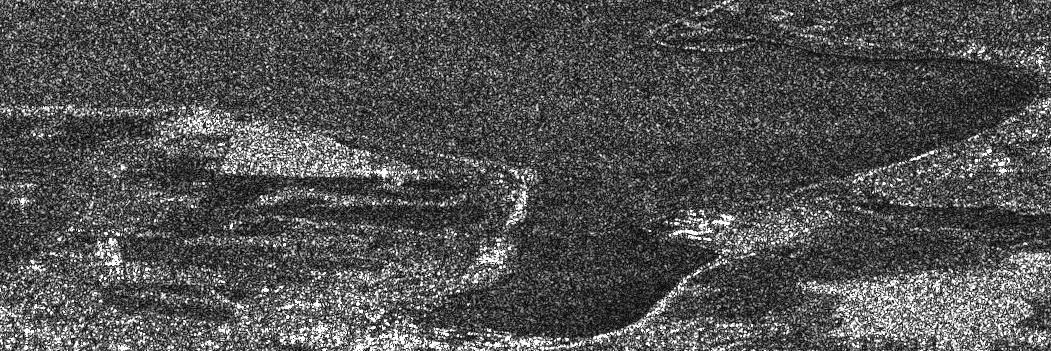

In [16]:
data_path, meta_path, calibration_path = Load.slc_paths(files[1], "VV", 3);

#### Lemvig

tmp_data = Load.slc_data(data_path, super_master_view);
img = SlcUtil.show_img(tmp_data)

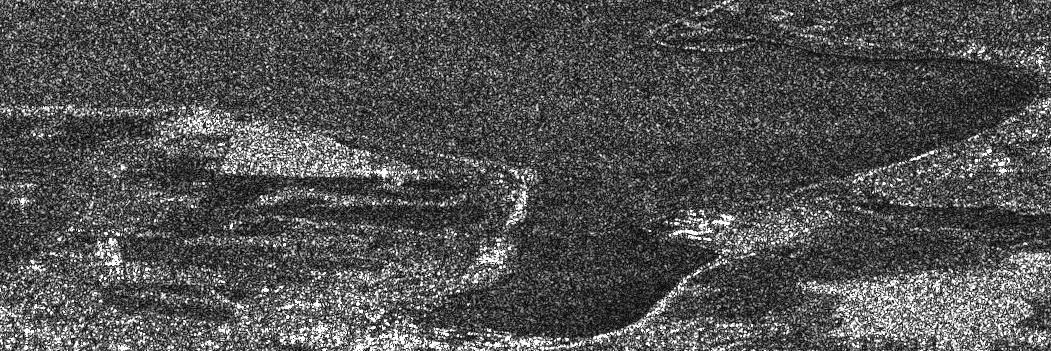

In [17]:
img = Gray.(abs.(img))

## Convert to png

In [18]:
result_folder

"/home/data/eigil/results/lemvig_interferogram"

In [19]:
intfg_files = readdir(result_folder)
index = [ split(elem, ".")[end] == "jld" for elem in intfg_files]
intfg_files = intfg_files[index];

In [20]:
interfergram_files = Array{String,1}(undef, 34);

In [21]:
#indexes = Array{Int, 35}
i = 1
for (index, file) in enumerate(intfg_files)
    tmp = split(file, "_")
    for elem in tmp
        if elem == "infgm"
            interfergram_files[i] = file
            i = i + 1
        end            
    end
end

In [22]:
intfg_paths = result_folder.*"/".*interfergram_files
dates = [split(elem, "_")[end][1:8] for elem in intfg_paths]
year = [d[1:4] for d in dates]
month = [d[5:6] for d in dates]
day = [d[7:8] for d in dates]
date_int = [parse.(Int, [year[k], month[k], day[k]]) for k in 1:length(dates)]
dates = [DateTime(date_int[k]...) for k in 1:length(dates)]
intfg_file_paths_sorted = intfg_paths[sortperm(dates)];
intfg_files_sorted = [rm_extension[1:end-4] for rm_extension in interfergram_files[sortperm(dates)]];

In [23]:
intfg_data = [JLD.load(file)["data"] for file in intfg_file_paths_sorted];

In [24]:
save_png_folder = "/home/data/eigil/results/lemvig_interferogram_png"

"/home/data/eigil/results/lemvig_interferogram_png"

In [25]:
for (index, im_data) in enumerate(intfg_data)
    img = SlcUtil.plot_phase.(im_data)
    img_path = joinpath(save_png_folder, "$(index)_"*intfg_files_sorted[index]*".png")
    FileIO.save(img_path, img);
end

In [53]:
for (index, im_data) in enumerate(intfg_data)
    img = SlcUtil.show_img(im_data)
    img_path = joinpath(save_png_folder, "amp_i$(index)_"*intfg_files_sorted[index]*".png")
    FileIO.save(img_path, img);
end

In [54]:
zip_folder(save_png_folder)

Process(`zip -q -j -r /home/data/eigil/results/lemvig_interferogram_png.zip /home/data/eigil/results/lemvig_interferogram_png`, ProcessExited(0))

In [100]:
save_png_folder = "/home/data/eigil/results/lemvig_interferogram_png_small"

"/home/data/eigil/results/lemvig_interferogram_png_small"

In [101]:
for (index, im_data) in enumerate(intfg_data)
    img = SlcUtil.plot_phase.(im_data[235:260, 480:515])
    img_path = joinpath(save_png_folder, "$(index)_"*intfg_files_sorted[index]*".png")
    FileIO.save(img_path, img);
end

In [102]:
for (index, im_data) in enumerate(intfg_data)
    img = SlcUtil.show_img(im_data[235:260, 480:515])
    img_path = joinpath(save_png_folder, "amp_i$(index)_"*intfg_files_sorted[index]*".png")
    FileIO.save(img_path, img);
end

In [103]:
zip_folder(save_png_folder)

Process(`zip -q -j -r /home/data/eigil/results/lemvig_interferogram_png_small.zip /home/data/eigil/results/lemvig_interferogram_png_small`, ProcessExited(0))